In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)


mpl.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rc('figure', figsize=(14, 10))#设置图片大小
sns.set_style('white')

%run Util.ipynb
%run Constant.ipynb
%run Policy_Loader.ipynb
%run BreakSectionManager.ipynb
%run Operation.ipynb
%run Evaluation.ipynb


# 沿着时间线，模拟买卖
class ProRocketRegression:
    
    def __init__(self,scale_start,scale_end,start_date,end_date,policy_name):
        self.scale_start = scale_start
        self.scale_end = scale_end
        
        self.start_date = start_date
        self.end_date = end_date
        self.policy_name = policy_name
        
        self.policy_loader = Policy_Loader(self.policy_name)
        self.debug = self.policy_loader.enabled_log_debug()
        self.context = self.policy_loader.get_context()
        
        self.level = self.context['level']
        self.short = self.context['short']
        self.mid = self.context['mid']
        self.account = Account(self.context,self.policy_name)
        
        self.operations={}
        
        
    def get_to_buy_candidate_stocks(self,cur_date,all_sections):
        already_bought = set(self.account.get_already_bought_symbols())
        
        part = all_sections[all_sections['d_s_date']==cur_date]
        
        if(part.shape[0]>0):
            stocks = part['symbol'].values
            
            for s in stocks:
                already_bought.add(s)
    
            if(self.debug==True):
                print(cur_date+' found to buy stocks '+ str(already_bought))
                
        return list(already_bought)
    
    
    def get_to_sell_candidate_stocks(self,cur_date):
        symbols = list(set(self.account.position.keys()))
        
        return symbols
        
    def get_all_sections(self):
        symbols = get_symbol_slices(self.scale_start,self.scale_end,data_dir)
        
        all_sections = pd.DataFrame(columns=break_section_columns)
        for symbol in symbols:
            sectionManager = BreakSectionManager(symbol,self.context)
            section_df = sectionManager.get_all_break_sections()
            
            all_sections = pd.concat([section_df,all_sections], ignore_index=True, sort=False)
            
        return all_sections
    
    def get_operation(self,symbol):
        if(symbol in self.operations):
            return self.operations[symbol]
        else:
            operation = Operation(self.account,symbol,self.context,self.policy_name)
            self.operations[symbol] = operation
            
            return operation
        
    
    def try_to_buy(self,cur_date,candidates):
        if(candidates is None):
            return
        
        for symbol in candidates:
            operation = self.get_operation(symbol)
        
            if(operation.is_buy_point(cur_date)==True):
                operation.open_opsition(cur_date)


    def try_to_sell(self,cur_date,candidates):
        for symbol in candidates:
            operation = self.get_operation(symbol)
            
            if(operation.is_sell_point(cur_date)==True):
                if(self.debug==True):
                    print('try to sell '+ symbol)

                operation.sell_stock(cur_date)
            
    def build_asset_file_path(self):
        return multip_report+'multip_stocks_account_asset_'+str(self.short)+'_'+str(self.mid)+'_'+self.level+'_'+operation_version+'.csv'
    
    def build_deal_file_path(self):
        return multip_report+'multip_stocks_deals_'+str(self.short)+'_'+str(self.mid)+'_'+self.level+'_'+operation_version+'.csv'
    
    def persist(self):
        self.account.get_asset_df().to_csv(self.build_asset_file_path(),index=False)
        self.account.deal_df.to_csv(self.build_deal_file_path(),index=False)
        
    def draw_asset(self):
        if(self.policy_loader.enable_painter()==True):
            painter = AssetPainter()

            asset_file = self.build_asset_file_path()
            painter.draw_month_profit_bars(asset_file)
            painter.draw_audit_asset_bars(asset_file)

    def start_regression(self):
        start_datetime = to_datetime(self.start_date)
        end_datetime = to_datetime(self.end_date)
        
        all_sections = self.get_all_sections()
        market = Metric('SH#999999',self.context)
        
        print('regression start scale['+str(self.scale_start)+','+str(self.scale_end)+']')
            
        while(start_datetime<=end_datetime):
            cur_date = start_datetime.strftime(YMD_format)
            
            if(market.is_today_open(cur_date)):
                self.account.daily_audit(cur_date)

                if(self.account.can_open_new_stock()==True):
                    candidates = self.get_to_buy_candidate_stocks(cur_date,all_sections)
                    self.try_to_buy(cur_date,candidates)
                    
                if(self.account.has_shares()==True):
                    candidates = self.get_to_sell_candidate_stocks(cur_date)
                    self.try_to_sell(cur_date,candidates)
                    
            start_datetime += dt.timedelta(days = 1)
            
            if((int(cur_date.split('-')[2])==28) and (int(cur_date.split('-')[1])==2)):
                print(cur_date,end=' ')
      
        self.persist()
        self.draw_asset()
        evaluation = Evaluation(self.account,self.context,self.policy_name)
        evaluation_df = evaluation.get_evaluation_report_of_multip_stocks(self.start_date,self.end_date)
        evaluation_df['scale_start'] = self.scale_start
        evaluation_df['scale_end'] = self.scale_end
        
        print('regression done !')
            
        return evaluation_df



<IPython.core.display.Javascript object>

In [ ]:
def demo():
    start = '2000-02-01'
    end = '2019-08-30'
    policy_name='rocket_break_v7_upgrade_honor_account_v0.2.json'

    regression = ProRocketRegression(0,60,start,end,policy_name)
    evaluation_df = regression.start_regression()
    
    columns = ['policy_name','short','mid','in_hand_asset_drawdown','avg_drawdown','float_profit_drawdown','avg_year_return',
              'year_regular_return','mean_year_return','std_year_return','mean_month_return','std_month_return','profit_month_rate']
    evaluation_df[columns]
    
    plt.rc('figure', figsize=(14,8))
    regression.account.asset['assets'].plot(kind='bar')
    plt.show()
    
    regression.account.asset['space_per'].plot(kind='bar')
    plt.show()
    
    return evaluation_df


# evaluation_df = demo()
# evaluation_df.T

regression start scale[0,120]
2000-02-28 2000-03-28 2000-04-28 2000-05-28 2000-06-28 2000-07-28 2000-08-28 2000-09-28 2000-10-28 2000-11-28 2000-12-28 2001-01-28 2001-02-28 2001-03-28 2001-04-28 2001-05-28 2001-06-28 2001-07-28 2001-08-28 2001-09-28 2001-10-28 2001-11-28 2001-12-28 2002-01-28 2002-02-28 2002-03-28 2002-04-28 2002-05-28 2002-06-28 2002-07-28 2002-08-28 2002-09-28 2002-10-28 2002-11-28 2002-12-28 2003-01-28 2003-02-28 2003-03-28 2003-04-28 2003-05-28 2003-06-28 2003-07-28 2003-08-28 2003-09-28 2003-10-28 2003-11-28 2003-12-28 2004-01-28 2004-02-28 2004-03-28 2004-04-28 2004-05-28 2004-06-28 2004-07-28 2004-08-28 2004-09-28 2004-10-28 2004-11-28 2004-12-28 2005-01-28 2005-02-28 2005-03-28 2005-04-28 2005-05-28 2005-06-28 2005-07-28 2005-08-28 2005-09-28 2005-10-28 2005-11-28 2005-12-28 2006-01-28 2006-02-28 2006-03-28 2006-04-28 2006-05-28 2006-06-28 2006-07-28 2006-08-28 2006-09-28 2006-10-28 2006-11-28 2006-12-28 2007-01-28 2007-02-28 2007-03-28 2007-04-28 2007-05-28 20

,policy_name,short,mid,in_hand_asset_drawdown,avg_drawdown,float_profit_drawdown,avg_year_return,year_regular_return,mean_year_return,std_year_return,mean_month_return,std_month_return,profit_month_rate
1,rocket_break_v7_upgrade_honor_account_v0.3.json,30,240,28.51,27.674519,41.79,81.25,81.29,6.973,26.701243,1.184541,7.602546,55.9


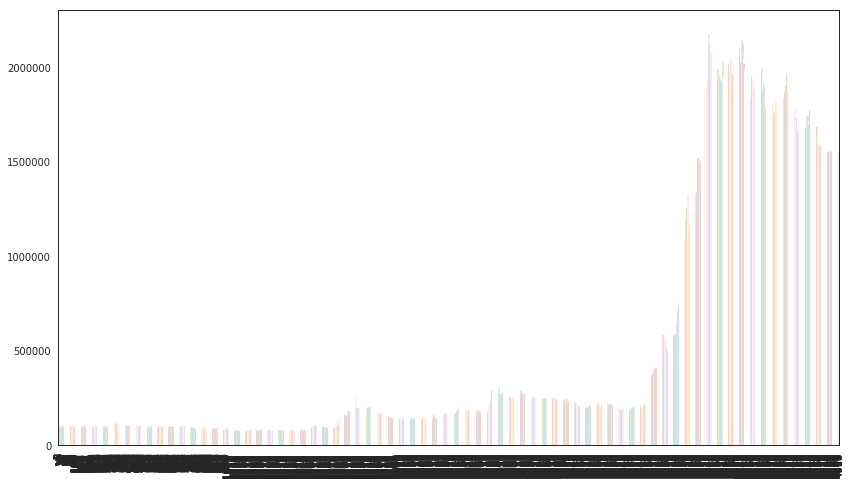

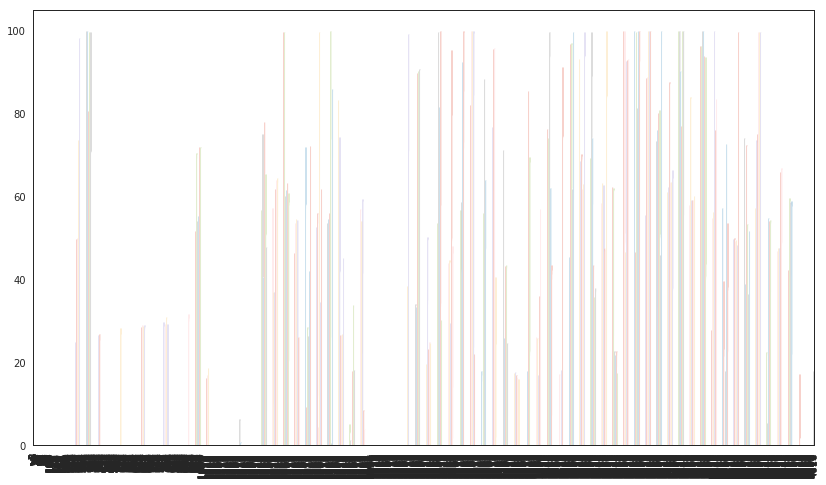

regression start scale[120,240]
2000-02-28 2000-03-28 2000-04-28 2000-05-28 2000-06-28 2000-07-28 2000-08-28 2000-09-28 2000-10-28 2000-11-28 2000-12-28 2001-01-28 2001-02-28 2001-03-28 2001-04-28 2001-05-28 2001-06-28 2001-07-28 2001-08-28 2001-09-28 2001-10-28 2001-11-28 2001-12-28 2002-01-28 2002-02-28 2002-03-28 2002-04-28 2002-05-28 2002-06-28 2002-07-28 2002-08-28 2002-09-28 2002-10-28 2002-11-28 2002-12-28 2003-01-28 2003-02-28 2003-03-28 2003-04-28 2003-05-28 2003-06-28 2003-07-28 2003-08-28 2003-09-28 2003-10-28 2003-11-28 2003-12-28 2004-01-28 2004-02-28 2004-03-28 2004-04-28 2004-05-28 2004-06-28 2004-07-28 2004-08-28 2004-09-28 2004-10-28 2004-11-28 2004-12-28 2005-01-28 2005-02-28 2005-03-28 2005-04-28 2005-05-28 2005-06-28 2005-07-28 2005-08-28 2005-09-28 2005-10-28 2005-11-28 2005-12-28 2006-01-28 2006-02-28 2006-03-28 2006-04-28 2006-05-28 2006-06-28 2006-07-28 2006-08-28 2006-09-28 2006-10-28 2006-11-28 2006-12-28 2007-01-28 2007-02-28 2007-03-28 2007-04-28 2007-05-28 

,policy_name,short,mid,in_hand_asset_drawdown,avg_drawdown,float_profit_drawdown,avg_year_return,year_regular_return,mean_year_return,std_year_return,mean_month_return,std_month_return,profit_month_rate
1,rocket_break_v7_upgrade_honor_account_v0.3.json,30,240,29.31,25.456365,45.81,46.48,46.43,5.73,25.702527,1.090873,7.013455,52.4


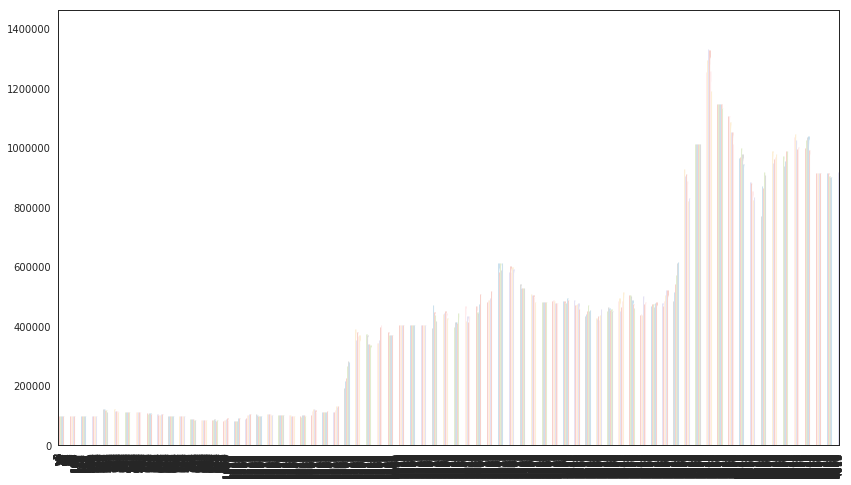

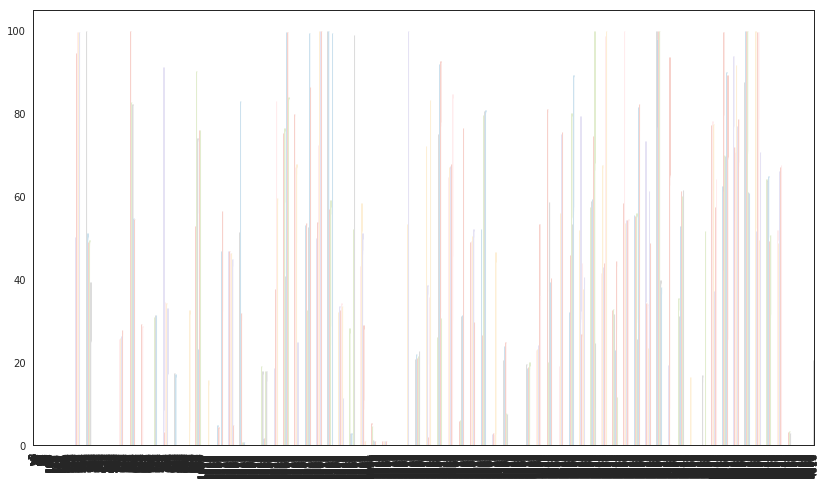

build SZ#000056 break sections
start to analyse Day level SZ#000056 all break sections...
build SZ#000631 break sections
start to analyse Day level SZ#000631 all break sections...
build SZ#000877 break sections
start to analyse Day level SZ#000877 all break sections...
build SZ#002063 break sections
start to analyse Day level SZ#002063 all break sections...
build SZ#002224 break sections
start to analyse Day level SZ#002224 all break sections...
build SZ#002386 break sections
start to analyse Day level SZ#002386 all break sections...
build SZ#002548 break sections
start to analyse Day level SZ#002548 all break sections...
build SZ#000058 break sections
start to analyse Day level SZ#000058 all break sections...
build SZ#000632 break sections
start to analyse Day level SZ#000632 all break sections...
build SZ#000878 break sections
start to analyse Day level SZ#000878 all break sections...
build SZ#002064 break sections
start to analyse Day level SZ#002064 all break sections...
build SZ#0

,policy_name,short,mid,in_hand_asset_drawdown,avg_drawdown,float_profit_drawdown,avg_year_return,year_regular_return,mean_year_return,std_year_return,mean_month_return,std_month_return,profit_month_rate
1,rocket_break_v7_upgrade_honor_account_v0.3.json,30,240,30.82,24.766134,40.52,250.04,250.5,13.3395,24.060032,1.582052,7.746304,56.33


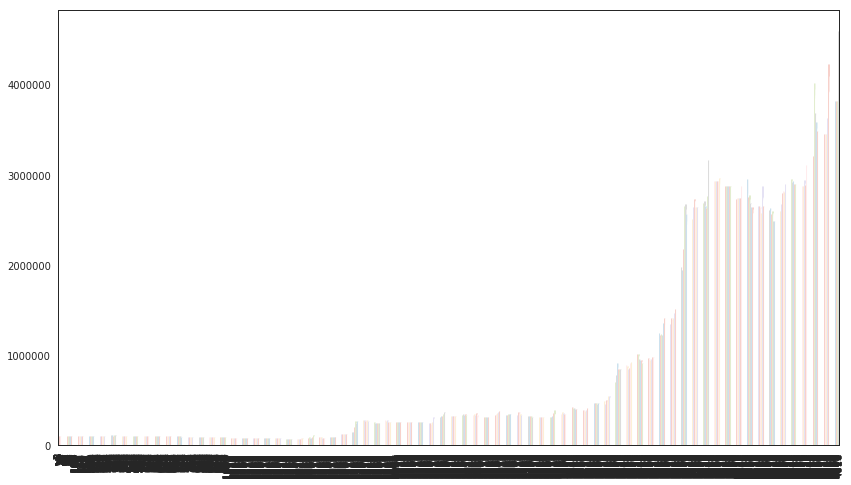

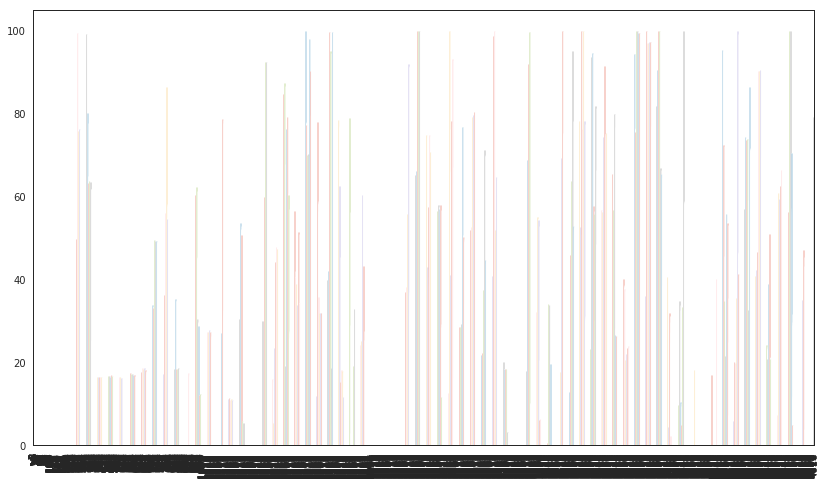

build SZ#002232 break sections
start to analyse Day level SZ#002232 all break sections...
build SZ#002394 break sections
start to analyse Day level SZ#002394 all break sections...
build SZ#002556 break sections
start to analyse Day level SZ#002556 all break sections...
build SZ#000068 break sections
start to analyse Day level SZ#000068 all break sections...
build SZ#000651 break sections
start to analyse Day level SZ#000651 all break sections...
build SZ#000888 break sections
start to analyse Day level SZ#000888 all break sections...
build SZ#002072 break sections
start to analyse Day level SZ#002072 all break sections...
build SZ#002233 break sections
start to analyse Day level SZ#002233 all break sections...
build SZ#002395 break sections
start to analyse Day level SZ#002395 all break sections...
build SZ#002557 break sections
start to analyse Day level SZ#002557 all break sections...
build SZ#000069 break sections
start to analyse Day level SZ#000069 all break sections...
build SZ#0

build SZ#002407 break sections
start to analyse Day level SZ#002407 all break sections...
build SZ#002569 break sections
start to analyse Day level SZ#002569 all break sections...
build SZ#000155 break sections
start to analyse Day level SZ#000155 all break sections...
build SZ#000669 break sections
start to analyse Day level SZ#000669 all break sections...
build SZ#000905 break sections
start to analyse Day level SZ#000905 all break sections...
build SZ#002085 break sections
start to analyse Day level SZ#002085 all break sections...
build SZ#002246 break sections
start to analyse Day level SZ#002246 all break sections...
build SZ#002408 break sections
start to analyse Day level SZ#002408 all break sections...
build SZ#002570 break sections
start to analyse Day level SZ#002570 all break sections...
build SZ#000156 break sections
start to analyse Day level SZ#000156 all break sections...
build SZ#000670 break sections
start to analyse Day level SZ#000670 all break sections...
build SZ#0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


OverflowError: cannot convert float infinity to integer

In [9]:
# 不同的选股对于算法稳定性的检查
def simulate(scale_start,scale_end):
    scale = 60
    start = '2000-02-01'
    end = '2019-08-30'
    policy_name='rocket_break_v7_upgrade_honor_account_v0.3.json'

    regression = ProRocketRegression(scale_start,scale_end,start,end,policy_name)
    evaluation_df = regression.start_regression()
    
    columns = ['policy_name','short','mid','in_hand_asset_drawdown','avg_drawdown','float_profit_drawdown','avg_year_return',
              'year_regular_return','mean_year_return','std_year_return','mean_month_return','std_month_return','profit_month_rate']
    display(evaluation_df[columns])
    plt.rc('figure', figsize=(14,8))
    regression.account.asset['assets'].plot(kind='bar')
    plt.show()
    
    plt.rc('figure', figsize=(14,8))
    regression.account.asset['space_per'].plot(kind='bar')
    plt.show()
    

# simulate(0,120)
# simulate(120,240)
# simulate(240,360)
# simulate(360,480)

